# Big Data Analytics for 4D Scanning Transmission Electron Microscopy Data

Supporting material for paper published in:<br>
**Scientific Reports** -  https://www.nature.com/articles/srep26348

Notebook written by:<br>
**Suhas Somnath, and Chris R. Smith**<br>
The Center for Nanophase Materials Science and The Institute for Functional Imaging for Materials <br>
Oak Ridge National Laboratory<br>
1/19/2017

Here, we will be working with four dimensional datasets acquired using a scanning transmission electron microscope (STEM). These datsets have four dimensions - two (x, y) dimensions from the position of the electron beam and each spatial pixel contains a two dimensional (u, v) image, called a **ronchigram**, recorded by the detector. Though the ronchigrams are typically averaged to two values (bright field, dark field), retaining the raw ronchigrams enables deeper investigation of data to reveal the existence of different phases in the material and other patterns that would typically not be visible in the averaged data

![notebook_rules.png](notebook_rules.png)

Image courtesy of Jean Bilheux from the [neutron imaging](https://github.com/neutronimaging/python_notebooks) GitHub repository.

## Configure the notebook first

In [1]:
# Ensure python 3 compatibility
from __future__ import division, print_function, absolute_import

import os

# Import necessary libraries:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, HTML
import ipywidgets as widgets
from sklearn.cluster import KMeans

import sys
sys.path.append('..')
sys.path.append('/Users/syz/PycharmProjects/pyUSID/')
sys.path.append('/Users/syz/PycharmProjects/pycroscopy/')
import pyUSID as usid
import pycroscopy as px

# Make Notebook take up most of page width
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

# set up notebook to show plots within the notebook
% matplotlib notebook
usid.plot_utils.use_nice_plot_params()

UsageError: Line magic function `%` not found.


## Load pycroscopy compatible 4D STEM dataset

For simplicity we will use a dataset that has already been translated form its original data format into a **Univeral Spectroscopy and Imaging Data (USID)** hierarchical data format (HDF5 or H5) file. For more information regarding USID, HDF5, etc. please see the documentation on our github projects

In [2]:
# Select a file to work on:
h5_path = './20120212_21_GB_float32_downsampled64x64_corrected.h5'
print('Working on:\n' + h5_path)
# Open the file
h5_file = h5py.File(h5_path, mode='r')

Working on:
./20120212_21_GB_float32_downsampled64x64_corrected.h5


OSError: Unable to open file (unable to open file: name = './20120212_21_GB_float32_downsampled64x64_corrected.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Look at the contents of this file:

In [7]:
usid.hdf_utils.print_tree(h5_file, main_dsets_only=True)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Mean_Ronchigram
    ├ Raw_Data
    ├ Raw_Data-SVD_000
      ----------------
      ├ U
      ├ U-Cluster_000
        -------------
        ├ Labels
        ├ Mean_Response
      ├ V
    ├ Spectroscopic_Mean


## Get reference to Raw measurement

In [12]:
# Select the dataset containing the raw data to start working with:
h5_main = usid.hdf_utils.find_dataset(h5_file, 'Raw_Data')[-1]

# Upgrade this object from a regular HDF5 dataset to a USIDataset:
h5_main = usid.USIDataset(h5_main)
print(h5_main)

<HDF5 dataset "Raw_Data": shape (25600, 4096), type "<f2">
located at: 
	/Measurement_000/Channel_000/Raw_Data 
Data contains: 
	Intensity (a. u.) 
Data dimensions and original shape: 
Position Dimensions: 
	X - size: 160 
	Y - size: 160 
Spectroscopic Dimensions: 
	U - size: 64 
	V - size: 64
Data Type:
	float16


### Operate on data in its original N-dimensional form:

In [14]:
stem_4d = h5_main.get_n_dim_form()
print(stem_4d.shape)

(160, 160, 64, 64)


The last two axes represent the row and columns of the ``ronchigram`` (think image or photograph) - i.e. the diffraction pattern observed at the detector every time the Scanning Transmission Electron Microscope (STEM) shoots a beam of electrons at a given location on  the sample. 

The first two axes represent the row and column locations on the sample where the diffraction patterns were collected.

### Probem: Visualize the Ronchigram at a single location on the sample:

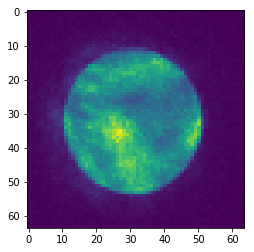

In [28]:
x = stem_4d[0,0]
x = np.float32(x)
fig, axis = plt.subplots()
axis.imshow(x)

### Problem: Visualize the Ronchigram at any few locations on the sample within the same figure:

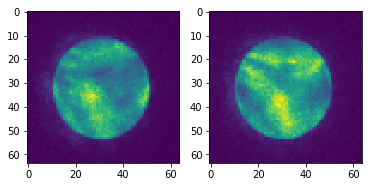

In [30]:
y = stem_4d[1,1]
y = np.float32(y)
fig, axis = plt.subplots(ncols=2)
axis[0].imshow(x)
axis[1].imshow(y)

### Problem: Visualize the spatial map of the sample for a given spot / pixel in the ronchigram:

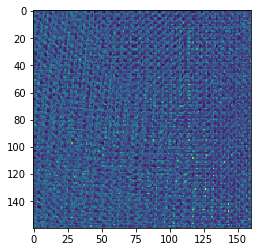

In [54]:
x = stem_4d[:,:,32,32]
x = np.float32(x)
fig, axis = plt.subplots()
axis.imshow(x)

### Problem: What does the ronchigram look like if averaged over all locations of the sample?

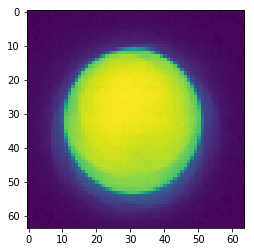

In [53]:
z = np.mean(stem_4d, axis=0)
a = np.mean(z, axis=0)
a = np.float32(a)
fig, axis = plt.subplots()
axis.imshow(a)

### Problem: Visualize the spatial map of the sample when the ronchigrams are averaged to a single value:

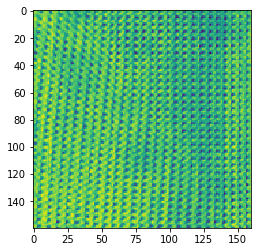

In [90]:
z = np.mean(stem_4d, axis=2)
a = np.mean(z, axis=2)
a = np.float32(a)
fig, axis = plt.subplots()
axis.imshow(a)

## Sub-divisions of detectors:
The Detector of the STEM is typically broken into multiple rigs and discs as shown below:
![TEM](./TEM_schematic.png "Simplified schematic of a TEM")

The portion of the ronchigram collected over each sub-detector is typically averaged to a single value for simplicity. 

Your goal in the next section will be to look at what the spatial maps look like for the signal collected at each detector.

## Masks
We essentially need to create and apply masks to the ronchigrams. For example, for the BF detector, we want to average over regions outside the central spot. Therefore, the mask should be 0 in the center and 1 outisde the perimeter. A convenient way to create the mask is to make a radially symmetric space, and plot an error function in it.

In [56]:
test = np.random.randint(0, high=10, size=(5,5))
mask = np.zeros((5, 5), dtype=np.uint16)
mask[2:4, 2:4] = 1
print(test)
print(mask)
print(test * mask)

[[1 5 6 7 8]
 [3 3 1 2 8]
 [8 8 4 5 9]
 [8 4 0 8 6]
 [7 7 0 3 6]]
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 1 1 0]
 [0 0 1 1 0]
 [0 0 0 0 0]]
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 4 5 0]
 [0 0 0 8 0]
 [0 0 0 0 0]]


### Read some necessary parameters:

In [58]:
h5_pos_inds = h5_main.h5_pos_inds
num_rows, num_cols = h5_main.pos_dim_sizes
h5_spec_inds = h5_main.h5_spec_inds
num_sensor_rows, num_sensor_cols = h5_main.spec_dim_sizes

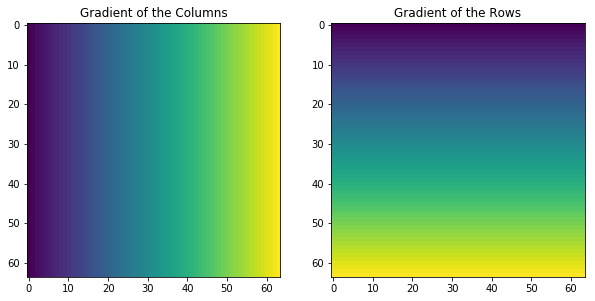

In [59]:
from scipy.special import erf
# build matrices that define regularly spaced grids over the ronchigram space
(u_mat2,v_mat2) = np.meshgrid(np.arange(-num_sensor_rows//2,num_sensor_rows//2,1),
                              np.arange(-num_sensor_cols//2,num_sensor_cols//2,1));

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
axes[0].imshow(u_mat2)
axes[0].set_title('Gradient of the Columns')
axes[1].imshow(v_mat2)
axes[1].set_title('Gradient of the Rows');

### Problem: Create a distance-from-center matrix / radial distance map using the two matrices above and visualize it:
Hint - consider using ``usid.plot_utils.plot_map(axis, image_matrix, show_cbar=True)`` instead of ``axis.imshow(image_matrix)`` to get a color bar

array([[45.254834  , 44.55333882, 43.8634244 , ..., 43.18564576,
        43.8634244 , 44.55333882],
       [44.55333882, 43.84062043, 43.13930922, ..., 42.44997055,
        43.13930922, 43.84062043],
       [43.8634244 , 43.13930922, 42.42640687, ..., 41.72529209,
        42.42640687, 43.13930922],
       ...,
       [43.18564576, 42.44997055, 41.72529209, ..., 41.01219331,
        41.72529209, 42.44997055],
       [43.8634244 , 43.13930922, 42.42640687, ..., 41.72529209,
        42.42640687, 43.13930922],
       [44.55333882, 43.84062043, 43.13930922, ..., 42.44997055,
        43.13930922, 43.84062043]])

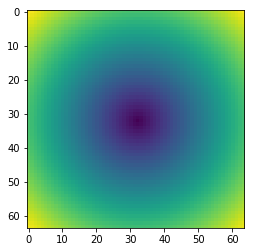

In [63]:
cir_mat = np.sqrt(u_mat2**2 + v_mat2**2)
fig, axis = plt.subplots()
axis.imshow(cir_mat)
cir_mat

### Problem: Create the mask for the ``BF-STEM`` Detector and visualize it:

In [92]:
mask = cir_mat < 13
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

### Problem: Apply the ``BF-STEM`` mask to the original dataset:
Hint: You will need to multiply the mask with the 4D dataset. See what that looks like.

In [94]:
filtered = stem_4d*mask

Recall that the ronchigram signal collected by each detector is averaged to a single value for each location of the electron  beam. Your masked dataset is still a 4D dataset that needs to be averaged to a 2D dataset
### Problem: Reduce this dataset to a 2D image and visualize
Hint: consider using the ``numpy.mean()`` function

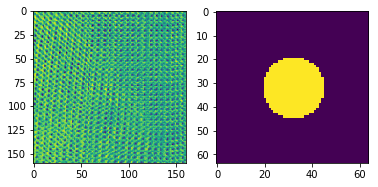

In [95]:
filtered = np.float32(filtered)
z = np.mean(filtered, axis=2)
a = np.mean(z, axis=2)
fig, axes = plt.subplots(ncols=2)
axes[0].imshow(a)
axes[1].imshow(np.float32(mask))

### Problem: Create the mask for the ``DF-STEM`` Detector and visualize it:

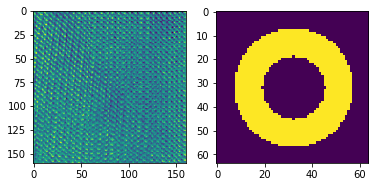

In [101]:
mask1 = (13 < cir_mat) & (cir_mat < 25)
filtered1 = stem_4d*mask1
filtered1 = np.float32(filtered1)
b = np.mean(filtered1, axis=2)
c = np.mean(b, axis=2)
fig, axes = plt.subplots(ncols=2)
axes[0].imshow(c)
axes[1].imshow(np.float32(mask1))

### Problem: Produce the averaged 2D spatial map that results from this mask applied to the 4D dataset:

### Problem: Create the mask for the ``HAADF-STEM`` Detector and visualize it:

The following will show how to handle n-dimensional data with Dask instead of NumPy

Import necessary modules for Dask

In [ ]:
import dask.array as da

Convert the 4-dimensional dataset into a Dask array.

In [ ]:
stem_4d_dask = da.from_array(stem_4d, chunks='auto') 

Visualize the Ronchigram at a single location on the sample

In [ ]:
x = stem_4d_dask[0,0]
x = x.astype('float32')
fig, axis = plt.subplots()
axis.imshow(x)

In [ ]:
Visualize the Ronchigram at any few locations on the sample within the same figure

In [ ]:
y = stem_4d_dask[1,1]
y = y.astype('float32')
fig, axis = plt.subplots(ncols=2)
axis[0].imshow(x)
axis[1].imshow(y)

Visualize the spatial map of the sample for a given spot / pixel in the ronchigram

In [ ]:
x = stem_4d_dask[:,:,32,32]
x = x.astype('float32')
fig, axis = plt.subplots()
axis.imshow(x)

What does the ronchigram look like if averaged over all locations of the sample?

In [ ]:
z = da.mean(stem_4d_dask, axis=0)
a = da.mean(z, axis=0)
a = a.astype('float32')
fig, axis = plt.subplots()
axis.imshow(a)

Visualize the spatial map of the sample when the ronchigrams are averaged to a single value:

In [ ]:
z = da.mean(stem_4d_dask, axis=2)
a = da.mean(z, axis=2)
a = a.astype('float32')
fig, axis = plt.subplots()
axis.imshow(a)

Masks

In [ ]:
test = da.random.randint(0, high=10, size=(5,5))
mask = da.zeros_like(test)
mask[2:4, 2:4] = 1
print(test)
print(mask)
print(test * mask)

Set up some parameters

In [ ]:
dask_pos_inds = da.asarray(h5_pos_inds, chunks='auto')
dask_num_rows = da.asarray(num_rows, chunks='auto')
dask_num_cols = da.asarrary(num_cols, chunks='auto')
dask_spec_inds = da.asarray(h5_spec_inds, chunks='auto')
dask_sensor_rows = da.asarray(num_sensor_rows, chunks='auto')
dask_sensor_cols = da.asarray(num_sensor_cols, chunks='auto')

Visualize gradient of columns and rows

In [ ]:
from scipy.special import erf
# build matrices that define regularly spaced grids over the ronchigram space
u_mat2, v_mat2 = da.meshgrid(da.arange(-dask_sensor_rows//2,dask_sensor_rows//2,1),
                              da.arange(-dask_sensor_cols//2,dask_sensor_cols//2,1))

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
axes[0].imshow(u_mat2)
axes[0].set_title('Gradient of the Columns')
axes[1].imshow(v_mat2)
axes[1].set_title('Gradient of the Rows');

In [16]:
h5_file.close()